In [1]:
!pip install -U irbasis3 xprec

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
!pip install jaxlib jax

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    'text.latex.preamble': r"\usepackage{amsmath}"
})

import irbasis3
from numpy.polynomial.legendre import leggauss

In [4]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax
from jax import numpy as jnp
from jax import grad, jit, vmap

In [5]:
def scale_quad(x, w, xmax, xmin):
    """ Scale weights and notes of quadrature to the interval [xmin, xmax] """
    assert xmin < xmax
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x + 1) + xmin
    return x_, w_

def _test_scale_quad():
    """ Integrate x^3 over [3, 0] """
    xmax = 3
    x_, w_ = leggauss(10)
    x, w = scale_quad(x_, w_, xmax, 0)
    f = lambda x: x**3
    res = np.sum(w * f(x))
    ref = 0.25*(xmax**4)
    assert np.abs(res - ref) < 1e-10

_test_scale_quad()

In [6]:
lambda_ = 100
beta = 10
wmax = lambda_/beta
K = irbasis3.KernelFFlat(lambda_=100)
basis = irbasis3.FiniteTempBasis(
    K, statistics='F', beta=beta, eps=1e-15)
print("dim", basis.size)
basis.s/basis.s[0]

dim 40


array([1.00000000e+00, 8.53837813e-01, 5.49145196e-01, 3.67374336e-01,
       2.19553524e-01, 1.29444220e-01, 7.30944043e-02, 4.02142528e-02,
       2.15029940e-02, 1.12086848e-02, 5.69932115e-03, 2.82957230e-03,
       1.37249433e-03, 6.50755177e-04, 3.01730842e-04, 1.36855975e-04,
       6.07396214e-05, 2.63844592e-05, 1.12196967e-05, 4.67141750e-06,
       1.90467209e-06, 7.60604097e-07, 2.97524206e-07, 1.14016108e-07,
       4.28098161e-08, 1.57509087e-08, 5.67942613e-09, 2.00720459e-09,
       6.95375963e-10, 2.36179493e-10, 7.86528074e-11, 2.56857635e-11,
       8.22688396e-12, 2.58465854e-12, 7.96632511e-13, 2.40915029e-13,
       7.14967895e-14, 2.08254045e-14, 5.95461498e-15, 1.67162105e-15])

In [7]:
dim = basis.size
u = basis.u
v = basis.v
svals = basis.s

In [23]:
def __oversample(x):
    xmid = 0.5*(x[1:] + x[:-1])
    return np.unique(np.hstack((x, xmid)))

def _oversample(x, n=1):
    for i in range(n):
        x = __oversample(x)
    return x

n_oversample = 1
roots = v[-1].roots()
smpl_points = _oversample(np.hstack((-wmax, roots, wmax)), n_oversample)
nsp = smpl_points.size
smpl_points

array([-1.00000000e+01, -9.96838328e+00, -9.93676657e+00, -9.80513744e+00,
       -9.67350831e+00, -9.44952028e+00, -9.22553225e+00, -8.92818695e+00,
       -8.63084165e+00, -8.28232565e+00, -7.93380965e+00, -7.55589518e+00,
       -7.17798072e+00, -6.78950724e+00, -6.40103377e+00, -6.01668277e+00,
       -5.63233177e+00, -5.26247922e+00, -4.89262667e+00, -4.54387044e+00,
       -4.19511422e+00, -3.87109628e+00, -3.54707834e+00, -3.24933844e+00,
       -2.95159854e+00, -2.68032019e+00, -2.40904184e+00, -2.16364426e+00,
       -1.91824668e+00, -1.69783498e+00, -1.47742328e+00, -1.28114985e+00,
       -1.08487643e+00, -9.12336752e-01, -7.39797077e-01, -5.91733325e-01,
       -4.43669572e-01, -3.22018253e-01, -2.00366934e-01, -1.00183467e-01,
       -1.17266461e-15,  1.00183467e-01,  2.00366934e-01,  3.22018253e-01,
        4.43669572e-01,  5.91733325e-01,  7.39797077e-01,  9.12336752e-01,
        1.08487643e+00,  1.28114985e+00,  1.47742328e+00,  1.69783498e+00,
        1.91824668e+00,  

In [24]:
# Projector from sampled values to \int dw rho(w)
prj_sum_rule = np.zeros(nsp)
for s in range(nsp-1):
    tmp = 0.5 * (smpl_points[s+1] - smpl_points[s])
    prj_sum_rule[s] += tmp
    prj_sum_rule[s+1] += tmp

In [25]:
# Projector from sampled values to rho_l
prj = np.zeros((svals.size, nsp))

x_, w_ = leggauss(10)

for s in range(nsp-1):
    x, w = scale_quad(x_, w_, smpl_points[s+1], smpl_points[s])
    dx = smpl_points[s+1] - smpl_points[s]
    f = (x - smpl_points[s])/dx
    g = ( smpl_points[s+1] - x)/dx
    for l in range(svals.size):
        prj[l, s+1] += np.sum(w * v[l](x) * f)
        prj[l, s] += np.sum(w * v[l](x) * g)

print("cond: ", np.linalg.cond(prj))

cond:  3.058242849978291


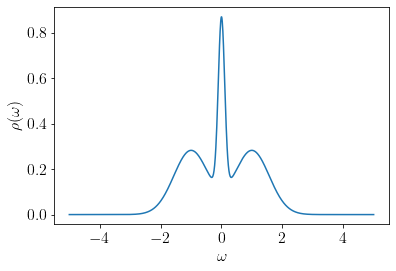

In [26]:
gaussian = lambda x, mu, sigma: np.exp(-((x-mu)/sigma)**2)/(np.sqrt(np.pi)*sigma)

rho = lambda omega: 0.2*gaussian(omega, 0.0, 0.15) + \
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = np.linspace(-5, 5, 1000)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
plt.plot(omegas, rho(omegas))

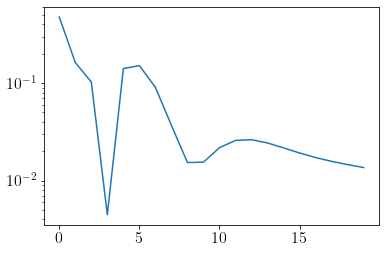

In [27]:
# Expand the spectral function in IR
x_, w_ = leggauss(10000)
x, w = scale_quad(x_, w_, wmax, -wmax)
all_l = np.arange(svals.size)

rhol = np.einsum('lw,w,w->l', v.value(all_l[:,None], x[None,:]), w, rho(x), optimize=True)

plt.semilogy(np.abs(rhol)[::2])

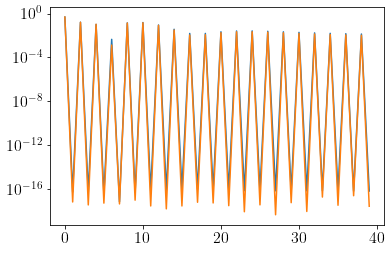

In [28]:
# Compute rho_l using projector
rhol2 = prj @ rho(smpl_points)

plt.semilogy(np.abs(rhol))
plt.semilogy(np.abs(rhol2))

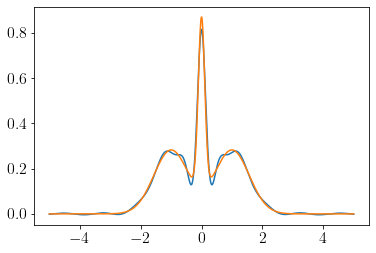

In [29]:
rho_reconst = np.einsum('lw,l->w', v.value(all_l[:,None], omegas[None,:]), rhol)

plt.plot(omegas, rho_reconst)
plt.plot(omegas, rho(omegas))

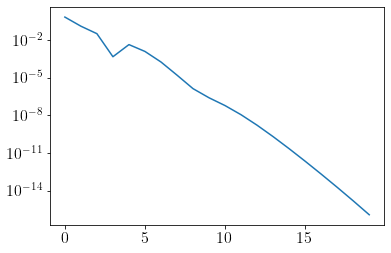

In [30]:
gl = - svals * rhol
plt.semilogy(np.abs(gl)[::2])

$$
\frac{1}{2} \sum_l |g_l + S_l \rho_l|^2 + \lambda \sum_l |\rho_l|
$$

In [55]:
from scipy.optimize import minimize

reg = 1e-5

def _cost2(gl, log_rho_omega, reg):
    rho_omega = jnp.exp(log_rho_omega)
    rhol = prj @ rho_omega
    return 0.5 * jnp.linalg.norm(gl + svals*rhol)**2 + reg * jnp.sum(jnp.abs(rhol))
    #return jnp.log(0.5 * jnp.linalg.norm(gl + svals*rhol)**2 + reg * jnp.sum(jnp.abs(rhol)))

gl_dirty = gl + 1e-5*np.random.randn(gl.size)
loss2 = lambda x: _cost2(gl_dirty, x, reg)
grad_loss2 = jit(grad(loss2))

In [60]:
#x0 = np.zeros(smpl_points.size)
x0 =  np.log(rho(smpl_points))
#callback = lambda x: print(loss2(x))

r = minimize(loss2, x0, method='BFGS', jac=jit(grad(loss2)), tol=1e-20, options={'gtol': 1e-20, 'maxiter': 100000}, callback=callback)

1.4320245082463925e-05
1.4156604559454545e-05
1.4050347000273738e-05
1.4017942893261253e-05
1.3772521307057088e-05
1.351064067935347e-05
1.3358105473955892e-05
1.3323068647570246e-05
1.3320681470494267e-05
1.3320569612892157e-05
1.3320472599599264e-05
1.3320295374815442e-05
1.3319967358867817e-05
1.3319368718227395e-05
1.3318565407644893e-05
1.3318200949937068e-05
1.3317617699969084e-05
1.3317520588514345e-05
1.3317371968889136e-05
1.3317310288106284e-05
1.3317155050167141e-05
1.331687328916032e-05
1.3316351711294555e-05
1.3315532525657148e-05
1.3315116919503812e-05
1.3314690076916843e-05
1.3313920584048846e-05
1.3312562492982264e-05
1.3310294888605738e-05
1.330670532154558e-05
1.3300863783718905e-05
1.3290609954400793e-05
1.3271890686565722e-05
1.3238687940143578e-05
1.3200844370939103e-05
1.3141982918957027e-05
1.3045591636967058e-05
1.2958359709140926e-05
1.293321117091384e-05
1.2923254620335229e-05
1.2906957766219391e-05
1.2884292576467513e-05
1.2865012499795823e-05
1.2841369538153

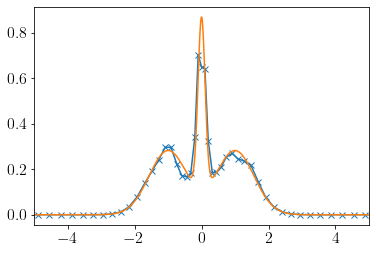

In [61]:
plt.xlim([-5, 5])
plt.plot(smpl_points, np.exp(r.x), marker='x')
plt.plot(omegas, rho(omegas))

0.6810125929186358


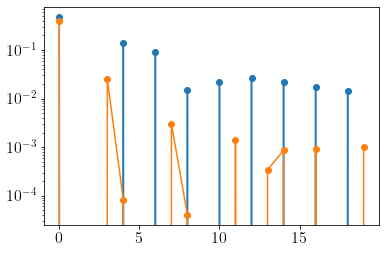

In [19]:
rhol_spm2 = prj @ np.exp(r.x)
print(prj_sum_rule @ np.exp(r.x))
plt.semilogy(rhol[::2], marker='o')
plt.semilogy(rhol_spm2[::2], marker='o')